In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import librosa

# Sklean
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# TensorFlow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


2025-05-26 17:09:11.761842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_mfcc(mfcc, fs):
    plt.figure(figsize=(12,6))    
    librosa.display.specshow(data=mfcc, sr=fs, x_axis='time', y_axis='linear', cmap='viridis')
    plt.title('MFCCs')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()


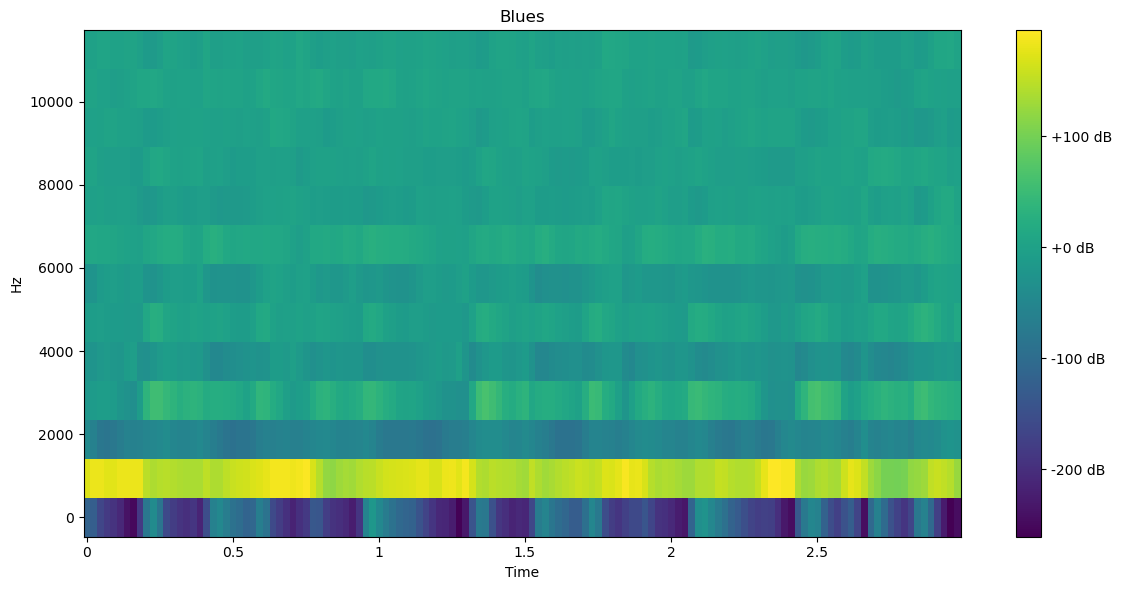

In [3]:
path_prefix = "/home/efectn/python-music-classification"
feature_path = os.path.join(path_prefix, "dataset/features_3.0_sec.json")
with open(feature_path, "r") as fp:
    data = json.load(fp)
    
idx = 100
fs = 22500
plot_mfcc(np.array(data["mfcc"])[idx].T, fs)
plt.title(f"{np.array(data['genre_name'])[idx].title()}");


In [4]:
X = np.array(data["mfcc"])
y = np.array(data["genre_num"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(f"X training data shape: {X_train.shape}, y training data shape: {y_train.shape}")
print(f"X validation data shape: {X_val.shape}, y validation data shape: {y_val.shape}")

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

def plot_history(hist):
    fig, axs = plt.subplots(2, 1, figsize=(8,7))
    fig.tight_layout(pad=2)
    
    axs[0].plot(hist.history["acc"], c='navy', label="Training Accuracy")
    axs[0].plot(hist.history["val_acc"], c='orange', label="Validation Accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")
    
    axs[1].plot(hist.history["loss"], c='navy', label="Training Loss")
    axs[1].plot(hist.history["val_loss"], c='orange', label="Validation Loss")    
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss")
    
    plt.show()

def make_prediction(model, X):
    global genres
    preds_num = []
    preds_name = []

    for X_current in X:
        X_current = X_current[np.newaxis, ...]
        pred = model.predict(X_current)
        pred = np.argmax(pred, axis=1)
        preds_num.append(pred[0])
        preds_name.append(genres[pred[0]])
        
    return preds_num, preds_name


X training data shape: (5593, 132, 13), y training data shape: (5593,)
X validation data shape: (1399, 132, 13), y validation data shape: (1399,)


In [19]:
model_dnn = Sequential()

model_dnn.add(Flatten(input_shape=(X.shape[1:3])))

model_dnn.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(10, activation='softmax'))

model_dnn.summary()

(132, 13)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 1716)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               879104    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                16448     
                                                                 
 dropout_8 (Dropout)         (None, 64)     

In [12]:
callbacks = [
             EarlyStopping(patience=10)
]

model_dnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

hist_dnn = model_dnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=250,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/250


2025-05-26 17:14:44.871295: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 38390352 exceeds 10% of free system memory.


88/88 [==============================] - 1s 6ms/step - loss: 3.9261 - acc: 0.1219 - val_loss: 3.4818 - val_acc: 0.1036
Epoch 2/250
88/88 [==============================] - 1s 7ms/step - loss: 3.7059 - acc: 0.1166 - val_loss: 3.4592 - val_acc: 0.1108
Epoch 3/250
88/88 [==============================] - 1s 6ms/step - loss: 3.5916 - acc: 0.1296 - val_loss: 3.4235 - val_acc: 0.1308
Epoch 4/250
88/88 [==============================] - 0s 5ms/step - loss: 3.5223 - acc: 0.1302 - val_loss: 3.3898 - val_acc: 0.1387
Epoch 5/250
88/88 [==============================] - 1s 6ms/step - loss: 3.4556 - acc: 0.1502 - val_loss: 3.3177 - val_acc: 0.1801
Epoch 6/250
88/88 [==============================] - 0s 5ms/step - loss: 3.3949 - acc: 0.1704 - val_loss: 3.2467 - val_acc: 0.2087
Epoch 7/250
88/88 [==============================] - 0s 5ms/step - loss: 3.3348 - acc: 0.1799 - val_loss: 3.2241 - val_acc: 0.2066
Epoch 8/250
88/88 [==============================] - 0s 5ms/step - loss: 3.3021 - acc: 0.1820 -

94/94 [==============================] - 0s 1ms/step - loss: 1.8774 - acc: 0.5455
Test Loss: 1.8774137496948242
Test Accuracy: 0.5455455183982849


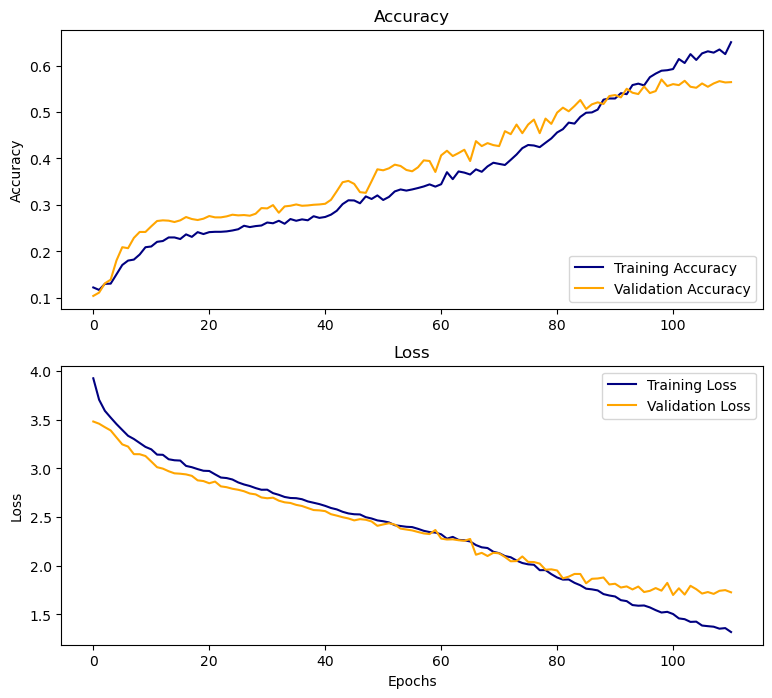

In [13]:
loss_dnn, acc_dnn = model_dnn.evaluate(X_test, y_test)
print(f"Test Loss: {loss_dnn}")
print(f"Test Accuracy: {acc_dnn}")
plot_history(hist_dnn)

In [14]:
preds_num, preds_name = make_prediction(model_dnn, X_test)

1/1 [==============================] - 0s 13ms/step


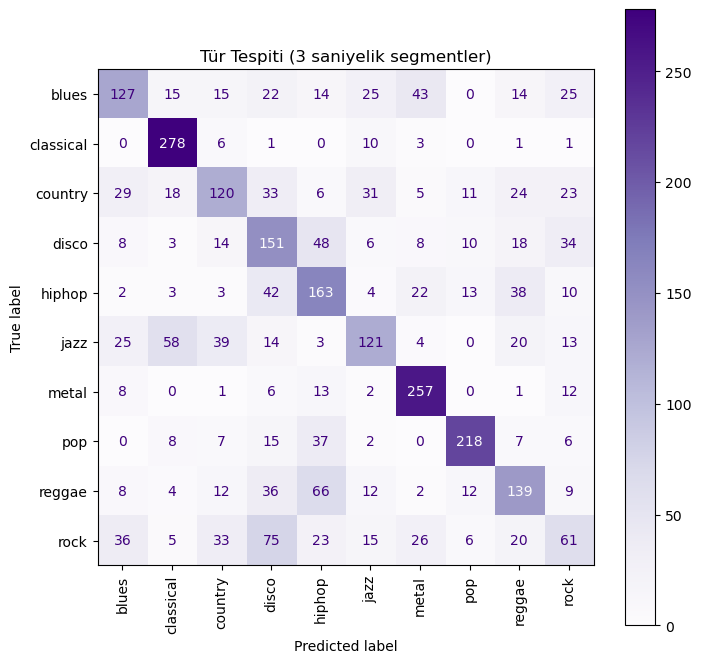

In [17]:
cm = confusion_matrix(y_test, preds_num)

fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(ax=ax, cmap = 'Purples', xticks_rotation='vertical')
plt.title('Tür Tespiti (3 saniyelik segmentler)');


In [18]:
model_dnn.save(os.path.join(path_prefix, "models/model_dnn.h5"))